In [3]:
import tensorflow as tf
import keras
tf.__version__

'2.16.1'

In [4]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    batch_size=32,
    image_size=(299, 299),
)

labels = dataset.class_names
labels

Found 9605 files belonging to 2 classes.


['benign', 'malignant']

In [5]:
def split_data(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * len(ds))
    test_size = int(test_split * len(ds))
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(test_size)
    test_ds = test_ds.take(test_size)
    return train_ds, test_ds, val_ds

In [6]:
train_ds, test_ds, val_ds = split_data(dataset)
len(train_ds), len(test_ds), len(val_ds)

(240, 60, 1)

In [35]:
resize_and_rescale = tf.keras.Sequential([
    keras.layers.Resizing(None,299, 299,3),
    keras.layers.Rescaling(1./255)
])

In [8]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False,
    pooling='avg',
    classifier_activation='softmax',
    classes=len(labels)
)

In [9]:
base_model.trainable = False

inputs = keras.Input(shape=(299, 299, 3))
x = resize_and_rescale(inputs)
x = base_model(x, training=False)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(len(labels), activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,010 (80.58 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [36]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=25
) 

Epoch 1/25


In [14]:
model.evaluate(test_ds)

60/60 ━━━━━━━━━━━━━━━━━━━━ 275s 4s/step - accuracy: 0.9766 - loss: 0.0670


[0.059084899723529816, 0.9822916388511658]

In [15]:
import os
os.makedirs('models', exist_ok=True)   

In [25]:
# Save the model in the native Keras format
model.save('models/model_80_classes.keras')



In [26]:
import tensorflow as tf
from keras.models import load_model

In [28]:
model = load_model("models/model_80_classes.keras")

C:\Users\Asus-2024\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 160 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [30]:
import numpy as np

def predict_image(image, target_size=(299, 299)):
    img = keras.preprocessing.image.load_img(
        image, target_size=target_size
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.sigmoid(predictions[0])
    print(f'Class: {labels[np.argmax(score)]}\nConfidence: {100 * np.max(score)}')
    return np.argmax(score)

In [32]:
idx = predict_image('data/benign/melanoma_15.jpg')
idx

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class: benign
Confidence: 73.08827042579651


0

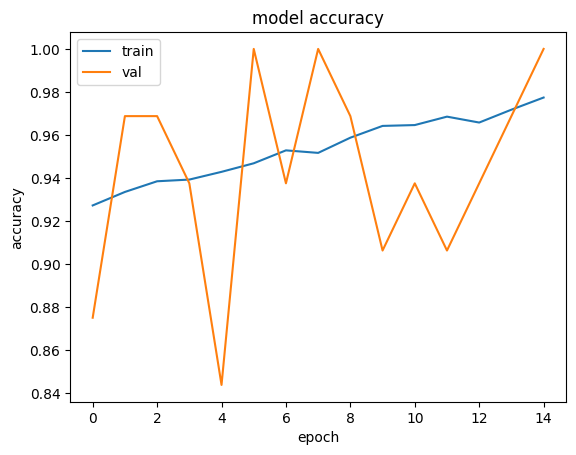

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()